In [1]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Проверяем наши даннные

In [2]:
osetr_paths = [
    os.path.join('Tensorflow', 'workspace', 'data', 'осетр 24.11 (1).21', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'осетр после опыта 2022', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'осетры пруды 2022', '')
]

karp_paths = [
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 один', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 два', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 три', ''),
    os.path.join('Tensorflow', 'workspace', 'data', 'клетки карпа 2022 четыре', '')
]

## Количество фотографий

In [6]:
def count_photos(paths):
    count = 0 
    for path in paths:
        for filename in os.listdir(path):
            if filename.endswith('.xml'):
                count += 1
    return count

In [7]:
count_photos(osetr_paths)

310

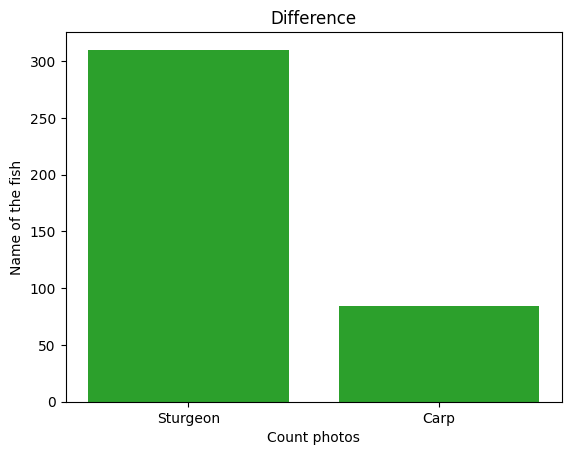

In [8]:
class_names = ['Sturgeon', 'Carp'] 
class_counts = [count_photos(osetr_paths), count_photos(karp_paths)]

# Create a bar plot
plt.bar(class_names, class_counts, color='tab:green')
plt.xlabel("Count photos")
plt.ylabel("Name of the fish")
plt.title("Difference")
plt.show()

## Распределение клеток

In [9]:
def count_classes(directory_path):
    class_counts = {}
    for path in directory_path:
        for filename in os.listdir(path):
            if filename.endswith('.xml'):
                tree = ET.parse(os.path.join(path, filename))
                root = tree.getroot()
    
                objects = root.findall('object')
                for object in objects:
                    name = object.find('name').text
                    if name in class_counts:
                        class_counts[name] += 1
                    else:
                        class_counts[name] = 1
    return class_counts

In [10]:
osetr_classes = count_classes(osetr_paths)

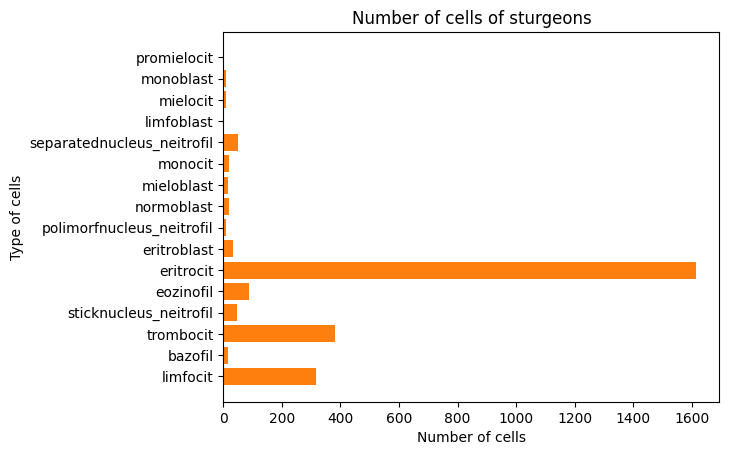

In [11]:
# Extract class counts from the dictionary
class_names = list(osetr_classes.keys())
class_counts = list(osetr_classes.values())

# Create a bar plot
plt.barh(class_names, class_counts, color='tab:orange')
plt.xlabel("Number of cells")
plt.ylabel("Type of cells")
plt.title("Number of cells of sturgeons")
plt.show()

In [12]:
karp_classes = count_classes(karp_paths)

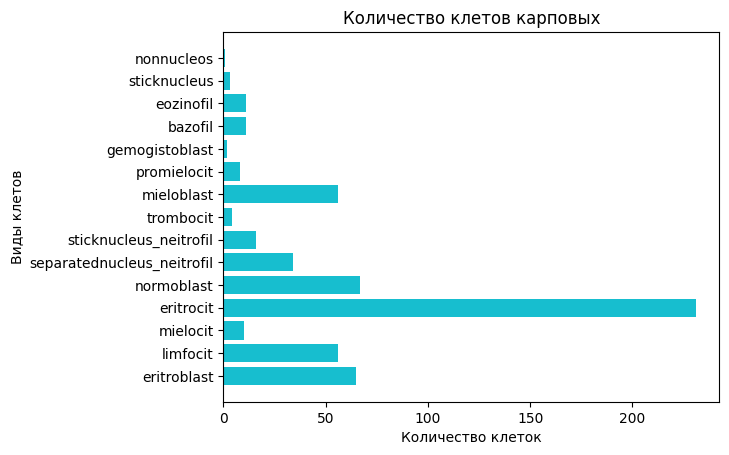

In [13]:
# Extract class counts from the dictionary
class_names = list(karp_classes.keys())
class_counts = list(karp_classes.values())

# Create a bar plot
plt.barh(class_names, class_counts, color='tab:cyan')
plt.xlabel("Количество клеток")
plt.ylabel("Виды клетов")
plt.title("Количество клетов карповых")
plt.show()

## График по количеству клеток на одном снимке

In [16]:
path_to_image = os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'train_old', '1 ленский-1') 

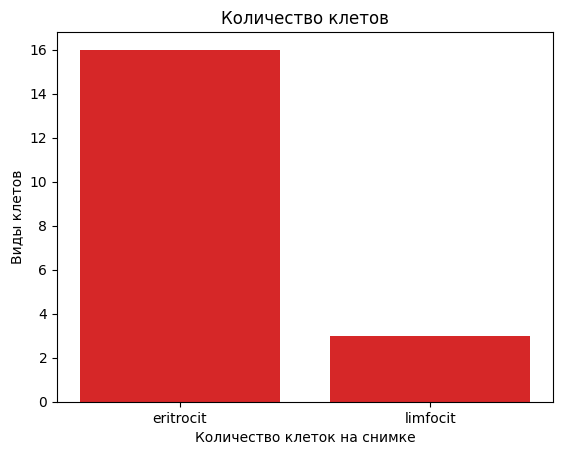

In [17]:
def count_cells(path):
    class_counts = {}
    tree = ET.parse(path + '.xml')
    root = tree.getroot()
    objects = root.findall('object')
    for object in objects:
        name = object.find('name').text
        if name in class_counts:
            class_counts[name] += 1
        else:
            class_counts[name] = 1
    return class_counts

cells = count_cells(path_to_image)

class_names = list(cells.keys())
class_counts = list(cells.values())
# Create a bar plot
plt.bar(class_names, class_counts, color='tab:red')
plt.xlabel("Количество клеток на снимке")
plt.ylabel("Виды клетов")
plt.title("Количество клетов")
plt.show()

## Пример вывода изображения 

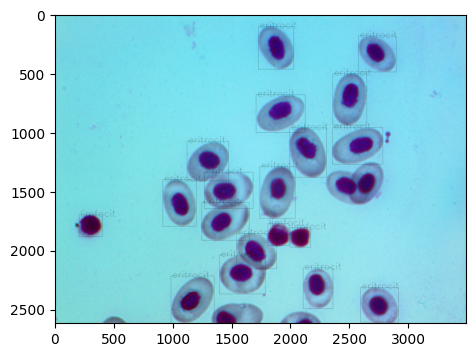

In [18]:
# Note that the function below is adapted from https://github.com/Shenggan/BCCD_Dataset
image = cv2.imread(path_to_image + '.jpg')
tree = ET.parse(path_to_image + '.xml')
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                cv2.rectangle(image, (xmin, ymin),
                            (xmax, ymax), (0, 0, 0), 1)
                cv2.putText(image, name, (xmin + 10, ymin + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 0), 1)
plt.figure(figsize=(9,4))
plt.imshow(image)
plt.show()

# Генерируем label_map.pbtxt

In [6]:
def parse_xml(filename):
    with open(filename) as f:
        tree = ET.parse(f)
        root = tree.getroot()

        classes = set()
        for obj in root.findall('object'):
            name = obj.find('name').text
            classes.add(name)

        return classes

def create_label_map(classes, path_to_data):
    classes = list(classes)
    if path_to_data[-12:-7] == 'osetr':
        label_map_name = 'label_map_osetr.pbtxt'
    else:
        label_map_name = 'label_map_karp.pbtxt'
    with open(ANNOTATIONS_PATH + label_map_name, 'w') as f:
        f.write('item {\n')
        f.write(' id: 1\n')
        f.write(' name: \"%s\"\n' % classes[0])
        f.write('}\n')

        for i in range(1, len(classes)):
            f.write('item {\n')
            f.write(' id: %d\n' % (i + 1))
            f.write(' name: \"%s\"\n' % classes[i])
            f.write('}\n')

In [7]:
TRAIN_PATH = os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'train', '')
TEST_PATH = os.path.join('Tensorflow', 'workspace', 'data', 'osetr', 'test', '')
ANNOTATIONS_PATH = os.path.join('Tensorflow', 'workspace', 'annotations', '')

In [8]:
# TRAIN_PATH = os.path.join('Tensorflow', 'workspace', 'data', 'karp', 'train', '')
# TEST_PATH = os.path.join('Tensorflow', 'workspace', 'data', 'karp', 'test', '')
# ANNOTATIONS_PATH = os.path.join('Tensorflow', 'workspace', 'annotations', '')

In [9]:
classes = set()
paths = [TRAIN_PATH, TEST_PATH]
for path in paths:
    for filename in os.listdir(path):
        if filename.endswith('.xml'):
            classes.update(parse_xml(path + '%s' % filename))
    print(classes, len(classes))
    create_label_map(classes, path)

{'limfocit', 'monocit', 'eozinofil', 'sticknucleus_neitrofil', 'separatednucleus_neitrofil', 'normoblast', 'eritroblast', 'eritrocit', 'trombocit'} 9
{'limfocit', 'monocit', 'eozinofil', 'sticknucleus_neitrofil', 'separatednucleus_neitrofil', 'normoblast', 'eritroblast', 'eritrocit', 'trombocit'} 9


# Запуск скрипта для перевода трансформации xml в record

In [10]:
TRAIN_PATH[-12:-7]

'osetr'

In [11]:
# ошибка с gfile https://github.com/tensorflow/tensorflow/issues/31315 (нужно зименить gfile на io.gfile)
if TRAIN_PATH[-12:-7] == 'osetr':
    label_map_name = 'label_map_osetr.pbtxt'
    record_train_name = 'osetr_train.record'
    record_test_name = 'osetr_test.record'
    %run Tensorflow/scripts/generate_tfrecord.py -x {TRAIN_PATH} -l {os.path.join(ANNOTATIONS_PATH, label_map_name)} -o {os.path.join(ANNOTATIONS_PATH, 'osetr_train.record')}
    %run Tensorflow/scripts/generate_tfrecord.py -x {TEST_PATH} -l {os.path.join(ANNOTATIONS_PATH, label_map_name)} -o {os.path.join(ANNOTATIONS_PATH, 'osetr_test.record')}
else:
    label_map_name = 'label_map_karp.pbtxt'
    record_train_name = 'karp_train.record'
    record_test_name = 'karp_test.record'
    %run Tensorflow/scripts/generate_tfrecord.py -x {TRAIN_PATH} -l {os.path.join(ANNOTATIONS_PATH, label_map_name)} -o {os.path.join(ANNOTATIONS_PATH, 'karp_train.record')}
    %run Tensorflow/scripts/generate_tfrecord.py -x {TEST_PATH} -l {os.path.join(ANNOTATIONS_PATH, label_map_name)} -o {os.path.join(ANNOTATIONS_PATH, 'karp_test.record')}


Successfully created the TFRecord file: Tensorflow/workspace/annotations/osetr_train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/osetr_test.record


# Проверяем правильность tfrecord

In [12]:
import Tensorflow.scripts.validate_tfrecords as validation

In [13]:
validation.validate_tfrecords([ANNOTATIONS_PATH + 'osetr_train.record', ANNOTATIONS_PATH + 'osetr_test.record'])

Validating Tensorflow/workspace/annotations/osetr_train.record
Checked 693 records in Tensorflow/workspace/annotations/osetr_train.record
Validating Tensorflow/workspace/annotations/osetr_test.record
Checked 1035 records in Tensorflow/workspace/annotations/osetr_test.record
Total records checked: 1035


2024-07-28 18:55:53.488815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-28 18:55:53.549316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-28 18:55:53.549749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
validation.validate_tfrecord_crc([ANNOTATIONS_PATH + 'osetr_train.record', ANNOTATIONS_PATH + 'osetr_test.record'])

Validating Tensorflow/workspace/annotations/osetr_train.record
Checked 693 records in Tensorflow/workspace/annotations/osetr_train.record
Validating Tensorflow/workspace/annotations/osetr_test.record
Checked 342 records in Tensorflow/workspace/annotations/osetr_test.record
Total records checked: 1035
Total records with bad length CRC: 0
Total records with bad data CRC: 0
